In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)


In [ ]:
df = pd.read_csv("cleaned_PJME_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')
df = df.sort_index()
df.head()


,PJME_MW,hour,dayofweek,month,year,day,is_weekend
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,0
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,0
2002-01-01 03:00:00,28357.0,3,1,1,2002,1,0
2002-01-01 04:00:00,27899.0,4,1,1,2002,1,0
2002-01-01 05:00:00,28057.0,5,1,1,2002,1,0


In [ ]:
df_lstm = df[['PJME_MW']].copy()

In [ ]:
scaler = MinMaxScaler()
df_lstm['PJME_MW_scaled'] = scaler.fit_transform(df_lstm[['PJME_MW']])

In [ ]:
def create_windowed_dataset(series, input_window, output_horizon=1):
    X, y = [], []
    for i in range(len(series) - input_window - output_horizon):
        X.append(series[i:i + input_window])
        y.append(series[i + input_window:i + input_window + output_horizon])
    return np.array(X), np.array(y).squeeze()


In [ ]:
input_window = 168  # 7 days of hourly data
output_horizon = 1  # predict 1 hour ahead

series = df_lstm['PJME_MW_scaled'].values
X, y = create_windowed_dataset(series, input_window, output_horizon)

print(f"X shape: {X.shape} | y shape: {y.shape}")


X shape: (145223, 168) | y shape: (145223,)


In [ ]:
n = len(X)
train_size = int(n * 0.7)
val_size = int(n * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (101656, 168), Val: (14522, 168), Test: (29045, 168)


In [ ]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

# Also save the scaler for inverse transform later
import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib
import matplotlib.pyplot as plt

In [ ]:
# Load windowed data
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the scaler to invert predictions later
scaler = joblib.load("scaler.save")


In [ ]:
# Currently: (samples, window)
# Reshape to (samples, window, 1 feature)
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]


In [ ]:
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output a single value (1-hour forecast)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sample = 10000
history = model.fit(
    X_train[:sample], y_train[:sample],
    epochs=5,
    batch_size=64,
    validation_data=(X_val[:sample], y_val[:sample]),
    verbose=1
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - loss: 6.3661e-04 - mae: 0.0194 - val_loss: 3.0590e-04 - val_mae: 0.0129
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - loss: 5.7850e-04 - mae: 0.0184 - val_loss: 2.8039e-04 - val_mae: 0.0122
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - loss: 5.3019e-04 - mae: 0.0176 - val_loss: 2.6080e-04 - val_mae: 0.0118
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - loss: 4.9360e-04 - mae: 0.0169 - val_loss: 1.9984e-04 - val_mae: 0.0106
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - loss: 4.8138e-04 - mae: 0.0167 - val_loss: 2.3099e-04 - val_mae: 0.0123


In [ ]:
# Predict
y_pred_scaled = model.predict(X_test)

# Invert scaling
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


908/908 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step
MAE: 561.23
RMSE: 687.62
MAPE: 1.89%


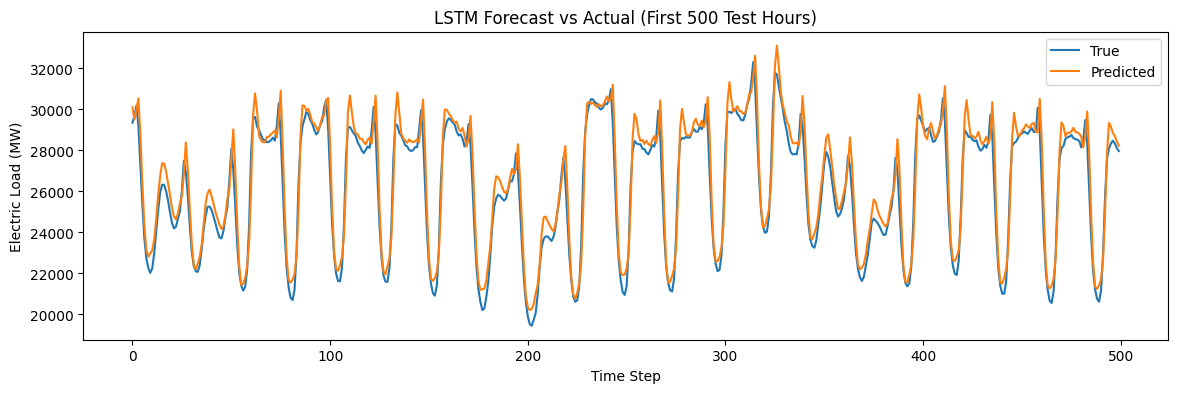

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(y_true[:500], label='True')
plt.plot(y_pred[:500], label='Predicted')
plt.title("LSTM Forecast vs Actual (First 500 Test Hours)")
plt.xlabel("Time Step")
plt.ylabel("Electric Load (MW)")
plt.legend()
plt.show()


# Multi - Output

In [ ]:
def create_multistep_dataset(series, input_window, output_horizon):
    X, y = [], []
    for i in range(len(series) - input_window - output_horizon):
        X.append(series[i:i + input_window])
        y.append(series[i + input_window:i + input_window + output_horizon])
    return np.array(X), np.array(y)


In [ ]:
input_window = 168   # past 7 days
output_horizon = 24  # next 24 hours

series = df_lstm['PJME_MW_scaled'].values
X, y = create_multistep_dataset(series, input_window, output_horizon)

print(f"X: {X.shape} | y: {y.shape}")


X: (145200, 168) | y: (145200, 24)


In [ ]:
n = len(X)
train_size = int(n * 0.7)
val_size = int(n * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Reshape for LSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(input_window, 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(output_horizon)  # Output = 24 hours
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,768 (77.22 KB)

 Trainable params: 19,768 (77.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sample = 10000
history = model.fit(
    X_train[:sample], y_train[:sample],
    epochs=5,
    batch_size=64,
    validation_data=(X_val[:sample], y_val[:sample]),
    verbose=1
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - loss: 0.0647 - mae: 0.1984 - val_loss: 0.0100 - val_mae: 0.0798
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - loss: 0.0108 - mae: 0.0819 - val_loss: 0.0048 - val_mae: 0.0545
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - loss: 0.0060 - mae: 0.0609 - val_loss: 0.0040 - val_mae: 0.0493
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - loss: 0.0050 - mae: 0.0552 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - loss: 0.0046 - mae: 0.0526 - val_loss: 0.0037 - val_mae: 0.0467


In [ ]:
y_pred_scaled = model.predict(X_test)

# Invert scaling for each step
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Metrics: Average across 24 steps
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Multi-step MAE: {mae:.2f}")
print(f"Multi-step RMSE: {rmse:.2f}")
print(f"Multi-step MAPE: {mape:.2f}%")


908/908 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step
Multi-step MAE: 2151.87
Multi-step RMSE: 2794.85
Multi-step MAPE: 6.95%


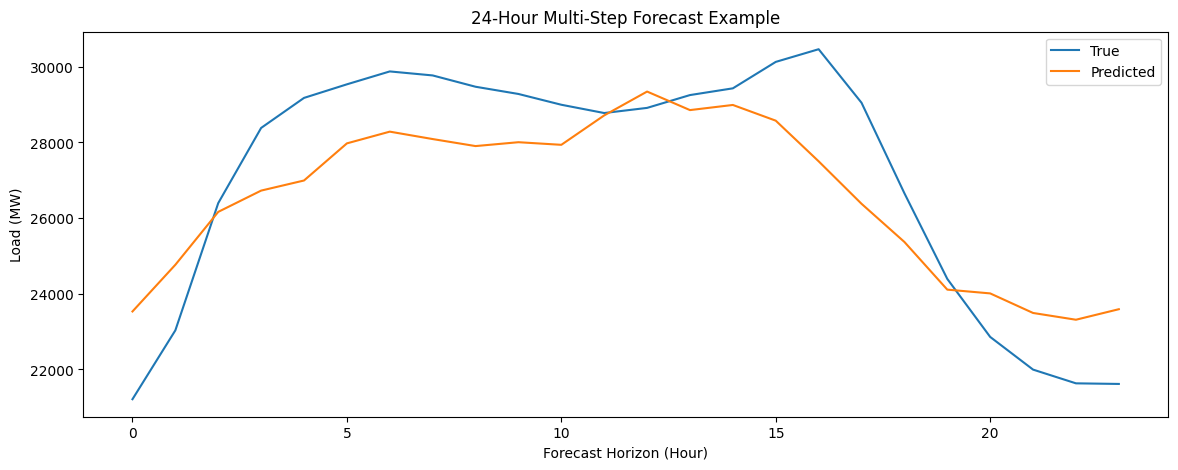

In [ ]:
sample_idx = 100

plt.figure(figsize=(14, 5))
plt.plot(y_true[sample_idx], label='True')
plt.plot(y_pred[sample_idx], label='Predicted')
plt.title("24-Hour Multi-Step Forecast Example")
plt.xlabel("Forecast Horizon (Hour)")
plt.ylabel("Load (MW)")
plt.legend()
plt.show()


In [ ]:
def predict_next_hours(model, input_sequence, scaler, input_window=168, output_horizon=24, plot=True):
    """
    Predict next `output_horizon` time steps using a trained multi-output LSTM model.

    Parameters:
    - model: Trained Keras LSTM model
    - input_sequence: 1D NumPy array of raw values (last `input_window` values)
    - scaler: Fitted MinMaxScaler used during training
    - input_window: Number of past hours used for prediction (e.g., 168 for 7 days)
    - output_horizon: Number of hours to predict (e.g., 24)
    - plot: Whether to plot the result

    Returns:
    - prediction: 1D NumPy array of predicted values (inverse transformed)
    """

    # Ensure input_sequence has right shape
    assert len(input_sequence) == input_window, f"Input sequence must be of length {input_window}"

    # Scale input
    input_scaled = scaler.transform(input_sequence.reshape(-1, 1)).flatten()

    # Reshape to 3D: (1 sample, input_window, 1 feature)
    X_input = input_scaled.reshape(1, input_window, 1)

    # Predict
    pred_scaled = model.predict(X_input)[0]  # shape: (output_horizon,)

    # Inverse transform predictions
    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # Optional plot
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(range(1, output_horizon + 1), pred, marker='o', label='Predicted')
        plt.title(f"Forecast for Next {output_horizon} Hours")
        plt.xlabel("Hour Ahead")
        plt.ylabel("Load (MW)")
        plt.grid()
        plt.legend()
        plt.show()

    return pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


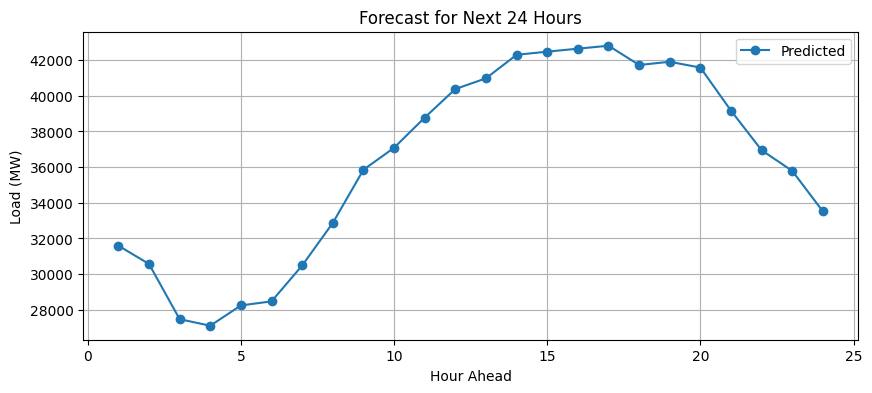

In [ ]:
# Use last 168 hours from the original dataset (after full preprocessing)
latest_sequence = df_lstm['PJME_MW'].values[-input_window:]

# Predict next 24 hours
next_24_hours = predict_next_hours(
    model=model,
    input_sequence=latest_sequence,
    scaler=scaler,
    input_window=168,
    output_horizon=24,
    plot=True
)
